In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

C:\Users\sinkur\Anaconda3\envs\ml1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sinkur\Anaconda3\envs\ml1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sinkur\Anaconda3\envs\ml1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sinkur\Anaconda3\envs\ml1\lib\site-packages\tensorflow\python\frame

In [3]:
class_names = ['Hip', 'Hip_Implant']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [4]:
def load_data():

    datasets = ['C:/Users/sinkur/Documents/Consulting/NHA/Ortho/Usecase_set/Hip_usecase/Dataset/train', 'C:/Users/sinkur/Documents/Consulting/NHA/Ortho/Usecase_set/Hip_usecase/Dataset/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  6%|▌         | 12/195 [00:00<00:01, 104.73it/s]

Loading C:/Users/sinkur/Documents/Consulting/NHA/Ortho/Usecase_set/Hip_usecase/Dataset/train


 50%|█████     | 18/36 [00:00<00:00, 168.87it/s]

Loading C:/Users/sinkur/Documents/Consulting/NHA/Ortho/Usecase_set/Hip_usecase/Dataset/test


100%|██████████| 77/77 [00:00<00:00, 169.70it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 426
Number of testing examples: 113
Each image is of size: (150, 150)


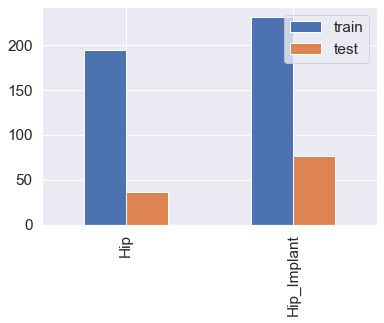

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

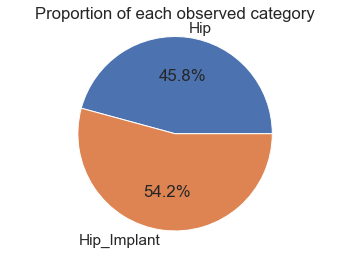

In [12]:
plt.pie(train_counts,explode=(0, 0) , labels=class_names,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [13]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [14]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

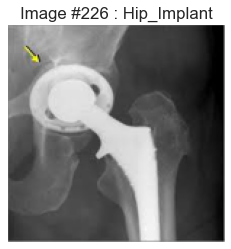

In [15]:
display_random_image(class_names, train_images, train_labels)

In [16]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

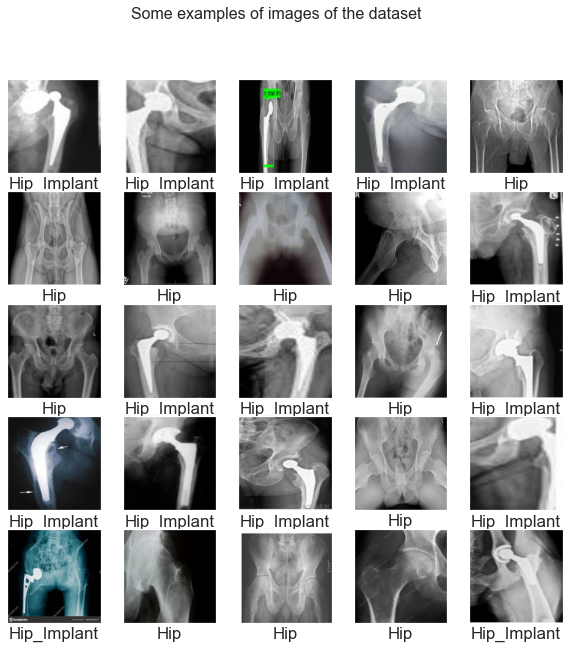

In [17]:
display_examples(class_names, train_images, train_labels)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='Hip_implant.h5',save_weights_only=False,monitor='val_acc', save_best_only=True,verbose=1)]

In [34]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2,callbacks=my_callbacks)

Train on 340 samples, validate on 86 samples
Epoch 1/20
256/340 [=====================>........] - ETA: 3s - loss: 2.5308 - acc: 0.5742
Epoch 00001: val_acc improved from -inf to 0.51163, saving model to Hip_implant.h5
340/340 [==============================] - 16s 47ms/sample - loss: 2.2621 - acc: 0.5794 - val_loss: 1.3893 - val_acc: 0.5116
Epoch 2/20
256/340 [=====================>........] - ETA: 3s - loss: 0.9817 - acc: 0.5859
Epoch 00002: val_acc did not improve from 0.51163
340/340 [==============================] - 15s 44ms/sample - loss: 0.9078 - acc: 0.5941 - val_loss: 0.6923 - val_acc: 0.5116
Epoch 3/20
256/340 [=====================>........] - ETA: 3s - loss: 0.7268 - acc: 0.5039
Epoch 00003: val_acc improved from 0.51163 to 0.86047, saving model to Hip_implant.h5
340/340 [==============================] - 16s 47ms/sample - loss: 0.6968 - acc: 0.5412 - val_loss: 0.5711 - val_acc: 0.8605
Epoch 4/20
256/340 [=====================>........] - ETA: 3s - loss: 0.5916 - acc: 0.69

In [35]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(20,15))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

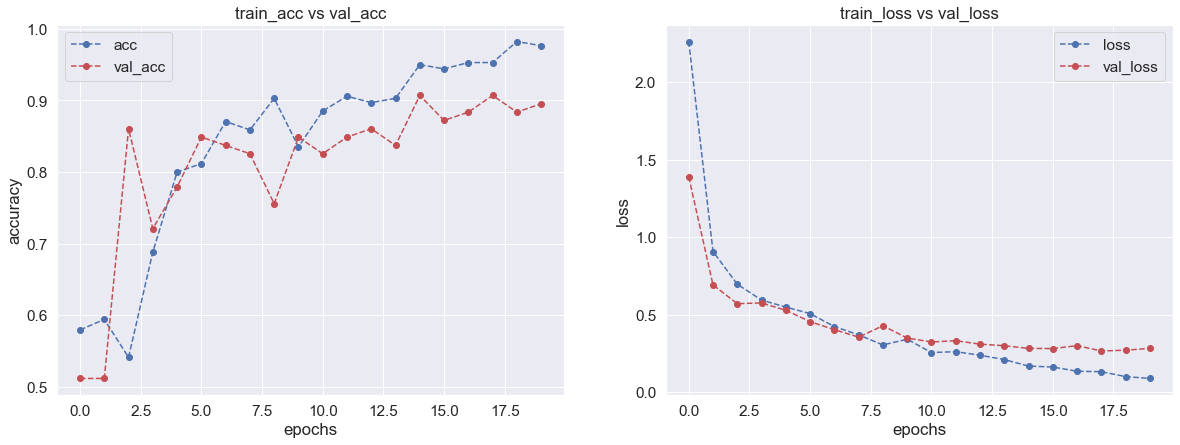

In [36]:
plot_accuracy_loss(history)

In [38]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


In [40]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [42]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape


In [43]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='Hip_implant.h5',save_weights_only=False,monitor='val_acc', save_best_only=True,verbose=1)]

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2,callbacks=my_callbacks)

Train on 340 samples, validate on 86 samples
Epoch 1/15
128/340 [==========>...................] - ETA: 0s - loss: 0.6543 - acc: 0.5703
Epoch 00001: val_acc improved from -inf to 0.90698, saving model to Hip_implant.h5
340/340 [==============================] - 1s 3ms/sample - loss: 0.6637 - acc: 0.6618 - val_loss: 0.1935 - val_acc: 0.9070
Epoch 2/15
128/340 [==========>...................] - ETA: 0s - loss: 0.2590 - acc: 0.8906
Epoch 00002: val_acc did not improve from 0.90698
340/340 [==============================] - 0s 190us/sample - loss: 0.3248 - acc: 0.8412 - val_loss: 0.2406 - val_acc: 0.8953
Epoch 3/15
128/340 [==========>...................] - ETA: 0s - loss: 0.2160 - acc: 0.9297
Epoch 00003: val_acc improved from 0.90698 to 0.91860, saving model to Hip_implant.h5
340/340 [==============================] - 0s 402us/sample - loss: 0.1905 - acc: 0.9265 - val_loss: 0.1708 - val_acc: 0.9186
Epoch 4/15
128/340 [==========>...................] - ETA: 0s - loss: 0.1999 - acc: 0.9375

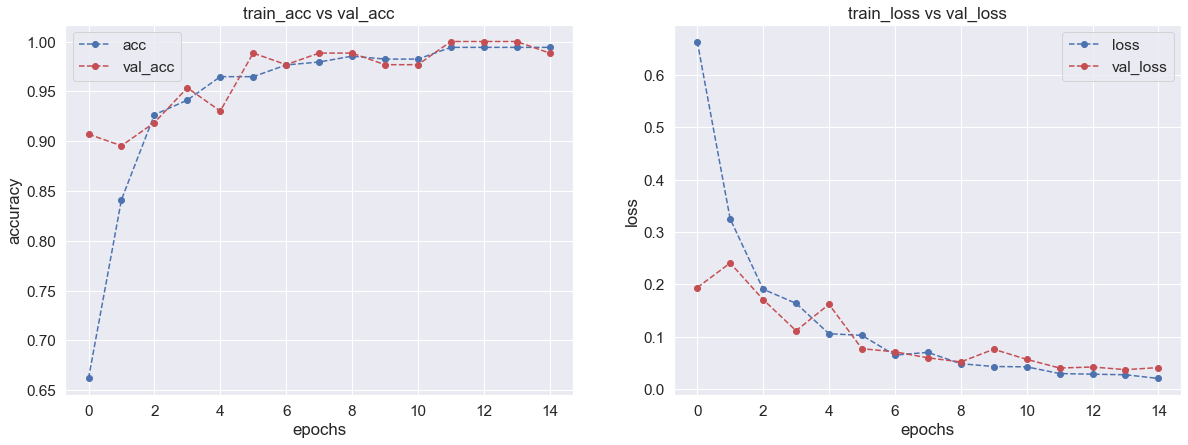

In [45]:
plot_accuracy_loss(history2)